In [34]:
from scgenome import tantalus
import pandas as pd
from IPython.display import display
from scgenome import utils, cncluster, simulation, cnplot
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import sklearn.metrics as skm

def get_mixture_labels(cn_data, obs_name="bhc_cluster_id", exp_name="origin_id_int"):
    sub_cn_data = cn_data[["cell_id", obs_name, exp_name]].drop_duplicates()
    return sub_cn_data

In [14]:
cn_data_fp = "/Users/massoudmaher/data/sc1935to37_spike_in_chrX.csv"
cn_data = pd.read_csv(cn_data_fp).iloc[:,1:]

In [27]:
hmmcopy_tickets = ['SC-1935', 'SC-1936', 'SC-1937']
sample_ids = [["SA922"], ['SA921'], ['SA1090']]

# spike in params
total_ncells = 100
proportions = [0.3, 0.3, 0.4]

# bhc params
n_states = 8
alpha = 3
prob_cn_change = 0.9
bhc_incon = 2 # inconsistent score used for making clusters from bhc
bhc_depth = 2 

# naive clusering params
naive_method = "complete"
naive_metric = "cityblock"
naive_incon = 1.1
naive_depth = 2

# Params for testing threshold values
params = simulation.expand_grid({"transform":["log","none"], "criterion": ["inconsistent"], "threshold": np.arange(0.025, 2, step=0.05)})
params = pd.concat([params, simulation.expand_grid({"transform":["log","none"], "criterion": ["distance"], "threshold": np.arange(3, 20, step=1)})])

In [16]:
start = time.time()
bhc_linkage, bhc_root, bhc_cell_ids, matrix_data, measurement, variances = (
    cncluster.bayesian_cluster(cn_data, n_states=n_states, alpha=alpha, prob_cn_change=prob_cn_change,
                               clustering_id="copy")
)
print(f"{time.time()-start}s for BHC on {total_ncells} cells")

/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


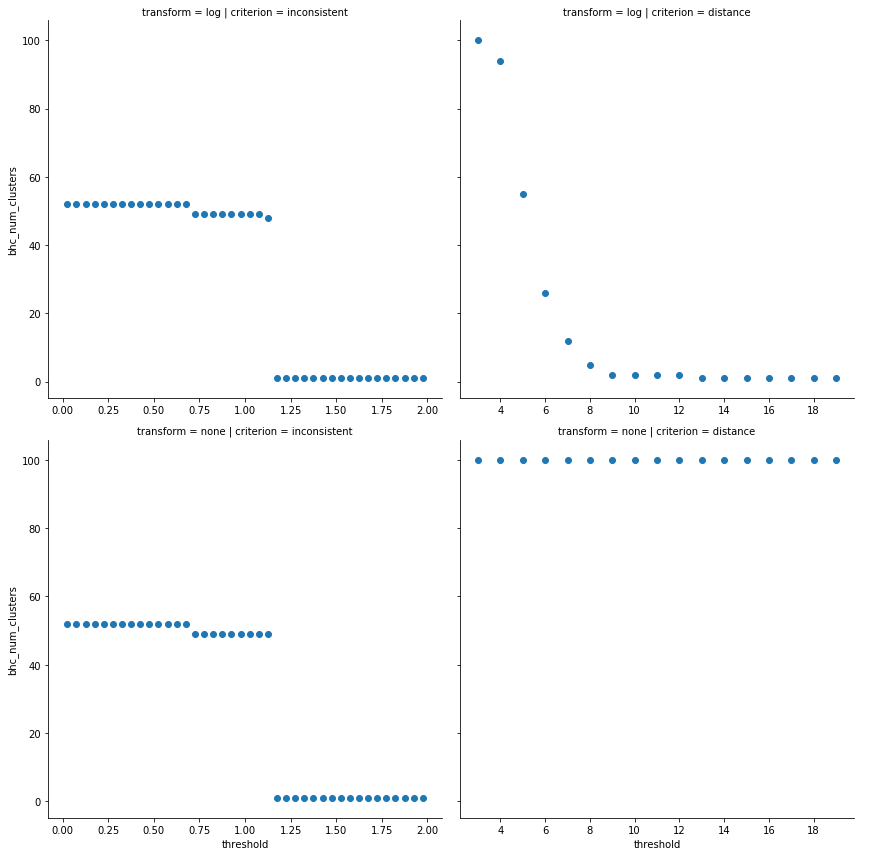

In [29]:
bhc_linkage, bhc_plot_data = simulation.get_plot_data(bhc_linkage)
lbhc_plot_data = bhc_plot_data.copy()
lbhc_plot_data[:,2] = np.log(bhc_plot_data[:,2]) # Log because the highest link is way higher

def apply_fn(row):
    if row["transform"] == "log":
        df = lbhc_plot_data
    else:
        df = bhc_plot_data
    return sch.fcluster(df, row["threshold"], criterion=row["criterion"])
params["bhc_fcluster"] = params.apply(apply_fn, axis=1)
params["bhc_num_clusters"] = params["bhc_fcluster"].apply(lambda x: len(set(x)))

g = sns.FacetGrid(data=params, col="criterion", row="transform", size=6, sharey=True, sharex=False).add_legend()
g = g.map(plt.scatter, "threshold", "bhc_num_clusters")

homogeneity: 0.5148151211620298, completeness: 0.44358881820239643, v-measure: 0.47655528490509197


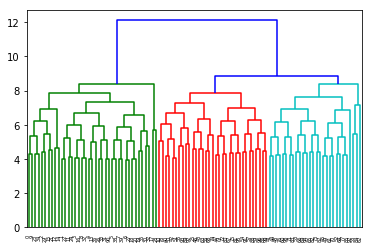

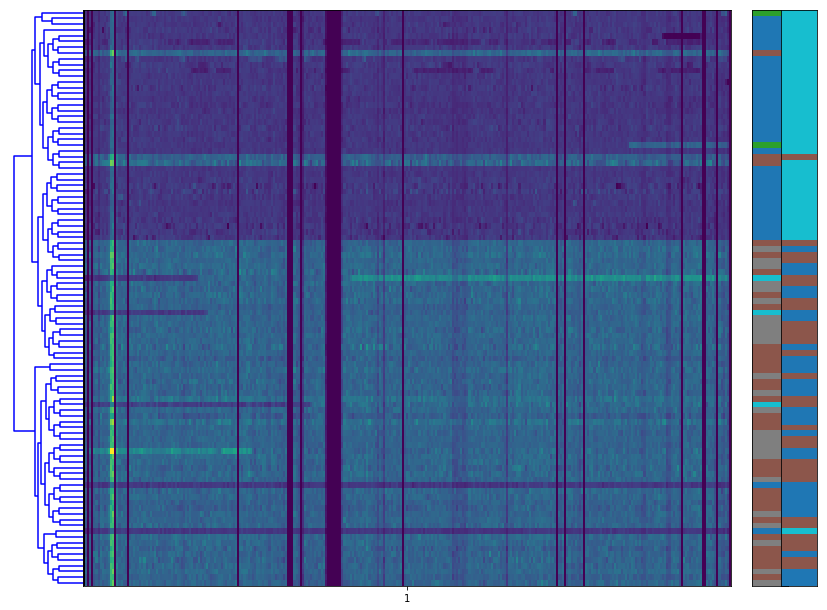

In [98]:
dend = sch.dendrogram(lbhc_plot_data)

bhc_clusters = sch.fcluster(lbhc_plot_data, 8, criterion="distance")
assert len(set(bhc_clusters)) > 1
cn_data = cncluster.prune_cluster(bhc_clusters, bhc_cell_ids, cn_data)
cn_data["origin_id_int"] = cn_data["origin_id"].factorize()[0]

fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, cn_data, "copy", cluster_field_name="bhc_cluster_id",
    linkage=lbhc_plot_data, origin_field_name="origin_id_int", raw=True)
clabels = get_mixture_labels(cn_data)
scores = skm.homogeneity_completeness_v_measure(clabels["origin_id_int"], clabels["bhc_cluster_id"])
print(f"homogeneity: {scores[0]}, completeness: {scores[1]}, v-measure: {scores[2]}")

In [39]:
display(bimatrix_data.head())
display(bimatrix_data.iloc[:,7])

cell_id           SA1090-A96213A-R29-C56 SA1090-A96213A-R35-C41  \
bhc_cluster_id                         2                      1   
origin_id_int                          2                      2   
cell_order                            0                      1    
chr_index start                                                   
22        1                            1                      1   
          500001                       1                      1   
          1000001                      1                      1   
          1500001                      1                      1   
          2000001                      1                      1   

cell_id           SA1090-A96213A-R33-C34 SA1090-A96213A-R35-C12  \
bhc_cluster_id                         1                      1   
origin_id_int                          2                      2   
cell_order                            2                      3    
chr_index start                                                   
22        1                            1                      1   
          500001                       1                      1   
          1000001                      1                      1   
          1500001                      1                      1   
          2000001                      1                      1   

cell_id           SA1090-A96213A-R28-C33 SA1090-A96213A-R20-C64  \
bhc_cluster_id                         1                      1   
origin_id_int                          2                      2   
cell_order                            4                      5    
chr_index start                                                   
22        1                            1                      1   
          500001                       1                      1   
          1000001                      1                      1   
          1500001                      1                      1   
          2000001                      1                      1   

cell_id           SA1090-A96213A-R22-C39 SA1090-A96213A-R33-C15  \
bhc_cluster_id                         1                      3   
origin_id_int                          2                      2   
cell_order                            6                      7    
chr_index start                                                   
22        1                            1                      2   
          500001                       1                      2   
          1000001                      1                      2   
          1500001                      1                      2   
          2000001                      1                      2   

cell_id           SA1090-A96213A-R24-C15 SA1090-A96213A-R34-C44  ...  \
bhc_cluster_id                         1                      1  ...   
origin_id_int                          2                      2  ...   
cell_order                            8                      9   ...   
chr_index start                                                  ...   
22        1                            1                      1  ...   
          500001                       1                      1  ...   
          1000001                      1                      1  ...   
          1500001                      1                      1  ...   
          2000001                      1                      1  ...   

cell_id           SA1090-A96213A-R24-C22 SA921-A90554A-R04-C52  \
bhc_cluster_id                         1                     3   
origin_id_int                          2                     1   
cell_order                            90                    91   
chr_index start                                                  
22        1                            1                     2   
          500001                       1                     2   
          1000001                      1                     2   
          1500001                      1                     2   
 

chr_index  start    
22         1            2
           500001       2
           1000001      2
           1500001      2
           2000001      2
           2500001      2
           3000001      2
           3500001      2
           4000001      2
           4500001      2
           5000001      2
           5500001      2
           6000001      2
           6500001      4
           7000001      4
           7500001      4
           8000001      4
           8500001      2
           9000001      2
           9500001      2
           10000001     2
           10500001     2
           11000001     2
           11500001     2
           12000001     2
           12500001     2
           13000001     2
           13500001     2
           14000001     2
           14500001     2
                       ..
           140500001    2
           141000001    2
           141500001    2
           142000001    2
           142500001    2
           143000001    2
           143500

In [41]:
cn_data[cn_data["cell_id"] == "SA1090-A96213A-R33-C15"].head()

,chr,start,end,reads,gc,copy,state,cell_id,sample_id,library_id,origin_id,origin_id_int,bhc_cluster_id
22392,X,1,500000,246,-1.000000,NaN,2,SA1090-A96213A-R33-C15,SA1090,A96213A,SC-1937,2,3
22393,X,500001,1000000,407,0.458294,1.503331,2,SA1090-A96213A-R33-C15,SA1090,A96213A,SC-1937,2,3
22394,X,1000001,1500000,296,-1.000000,NaN,2,SA1090-A96213A-R33-C15,SA1090,A96213A,SC-1937,2,3
22395,X,1500001,2000000,504,0.481712,1.859886,2,SA1090-A96213A-R33-C15,SA1090,A96213A,SC-1937,2,3
22396,X,2000001,2500000,477,-1.000000,NaN,2,SA1090-A96213A-R33-C15,SA1090,A96213A,SC-1937,2,3


In [75]:
np.where(bhc_cell_ids.to_numpy() == "SA1090-A96213A-R33-C15")

(array([25]),)

In [76]:
bhc_linkage[bhc_linkage["i"] == 25]

,i,j,r_merge,naive_dist,log_like,i_count,j_count,merge_count,dist,i_id,j_id
38,25,46,-96.956986,NaN,81.1385,1,1,2,96.956986,NaN,SA1090-A96213A-R35-C41


In [77]:
bhc_cell_ids[46]

'SA921-A90554A-R04-C52'

In [78]:
cn_data[cn_data["cell_id"] == 'SA921-A90554A-R04-C52'].head()

,chr,start,end,reads,gc,copy,state,cell_id,sample_id,library_id,origin_id,origin_id_int,bhc_cluster_id
10574,X,1,500000,283,-1.000000,NaN,2,SA921-A90554A-R04-C52,SA921,A90554A,SC-1936,1,3
10575,X,500001,1000000,394,0.458294,1.702092,2,SA921-A90554A-R04-C52,SA921,A90554A,SC-1936,1,3
10576,X,1000001,1500000,232,-1.000000,NaN,2,SA921-A90554A-R04-C52,SA921,A90554A,SC-1936,1,3
10577,X,1500001,2000000,461,0.481712,2.031446,2,SA921-A90554A-R04-C52,SA921,A90554A,SC-1936,1,3
10578,X,2000001,2500000,453,-1.000000,NaN,2,SA921-A90554A-R04-C52,SA921,A90554A,SC-1936,1,3


In [81]:
include_cells = ["SA1090-A96213A-R33-C15", 'SA921-A90554A-R04-C52', 'SA922-A90554B-R27-C44', 'SA922-A90554B-R30-C42']
small_cn = cn_data[cn_data["cell_id"].isin(include_cells)]

In [85]:
sm_linkage, sm_root, sm_cell_ids, sm_matrix_data, sm_measurement, sm_variances = (
    cncluster.bayesian_cluster(small_cn, n_states=n_states, alpha=alpha, prob_cn_change=prob_cn_change,
                               clustering_id="copy")
)

In [86]:
sm_linkage

,i,j,r_merge,naive_dist,log_like,i_count,j_count,merge_count
0,2,3,-81.558,NaN,79.3203,1,1,2
1,0,1,-96.957,NaN,81.1385,1,1,2
2,5,4,-232.615,NaN,105.665,2,2,4


In [87]:
sm_cell_ids

cell_id
SA1090-A96213A-R33-C15    SA1090-A96213A-R33-C15
SA921-A90554A-R04-C52      SA921-A90554A-R04-C52
SA922-A90554B-R27-C44      SA922-A90554B-R27-C44
SA922-A90554B-R30-C42      SA922-A90554B-R30-C42
Name: cell_id, dtype: object

In [89]:
display(measurement)

array([[       nan, 0.75660721,        nan, ..., 1.17535172, 0.81526686,
               nan],
       [       nan, 0.88828107,        nan, ..., 1.06299639, 0.77706014,
               nan],
       [       nan, 0.49157069,        nan, ..., 1.07157491, 0.87299665,
               nan],
       ...,
       [       nan, 1.97982397,        nan, ..., 2.14280342, 1.86783936,
               nan],
       [       nan, 1.74734084,        nan, ..., 1.97765099, 1.34041564,
               nan],
       [       nan, 1.6674791 ,        nan, ..., 2.14757623, 1.82898481,
               nan]])

In [95]:
sm_measurement

array([[       nan, 1.50333125,        nan, ..., 1.82497692, 1.45350786,
               nan],
       [       nan, 1.70209199,        nan, ..., 2.47667649, 1.60343329,
               nan],
       [       nan, 1.41281727,        nan, ..., 2.00463448, 1.3397103 ,
               nan],
       [       nan, 1.8447745 ,        nan, ..., 1.83157755, 1.58443762,
               nan]])

In [96]:
np.savetxt("/Users/massoudmaher/data/measurement.tsv", sm_measurement)